In [1]:
import numpy as np
from skyfield.api import load, Topos
import matplotlib.pyplot as plt

In [2]:
# Load ephemeris data
eph = load('de421.bsp')
earth, moon, sun = eph['earth'], eph['moon'], eph['sun']

ts = load.timescale()

#Calculation of the angular distance in equatorial coordinates
def angular_distance(ra1, dec1, ra2, dec2):
    ra1 = np.deg2rad(ra1 * 15)  # Convert hours to degrees
    ra2 = np.deg2rad(ra2 * 15)  # Convert hours to degrees
    dec1 = np.deg2rad(dec1)
    dec2 = np.deg2rad(dec2)
    cos_distance = np.sin(dec1) * np.sin(dec2) + np.cos(dec1) * np.cos(dec2) * np.cos(ra1 - ra2)
    distance = np.arccos(cos_distance)
    return np.rad2deg(distance)

#Only 3 months starting September 21st and ending December 20th (23 days in total)
d_9 = np.arange(21,31,4)
d_10 = np.arange(3,32,4)
d_11 = np.arange(4,31,4)
d_12 = np.arange(2,21,4)

In [3]:
from skyfield.api import EarthSatellite

#Ideal Satellite
line1_ideal = '1 00001U 20001A   24094.87500000  .00000000  00000-0  00000-0 0  0000'
line2_ideal = '2 00001   0.0000  0.0000 0000000  0.0000  0.0000  1.00000000  00000' # exactly 1 rev. per day
satellite_ideal = EarthSatellite(line1_ideal, line2_ideal, 'Ideal Satellite', ts)

This version is the current one, meaning that we calculate every 4th day and for every day every 30min. Also the safe position tests includes the points that are observable for 7 consecutive times. And the fields in the end are with distortion:

In [4]:
# The "containers" for all the equatorial coord values for the moon, earth and sun (order: RA, Dec)
moon_eq_values_24 = []
sun_eq_values_24 = []
earth_eq_values_24 = []

# Generate a grid of RA and Dec values
ra_grid = np.linspace(0, 24, 360)  # RA from 0 to 24 hours
dec_grid = np.linspace(-90, 90, 180)  # Dec from -90 to 90 degrees

In [5]:
# Trajectory of the moon every 30 minutes for 6 months every 4th day starting September 21st
for i in np.arange(9,13): # from September til December
    var = f'd_{i}'
    var_2 = globals()[var]
    for d in var_2:
        for h in np.arange(0,24):
            for m in np.arange(0,60,30):
                t = ts.utc(2024, i, d, h, m)
                astrometric = (earth + satellite_ideal).at(t).observe(moon)
                ra, dec, distance = astrometric.radec()
                moon_eq_values_24.append((ra.hours, dec.degrees)) 
        t = ts.utc(2024, i, d, 23, 59)
        astrometric = (earth + satellite_ideal).at(t).observe(moon)
        ra, dec, distance = astrometric.radec()
        moon_eq_values_24.append((ra.hours, dec.degrees))
            
#Trajectory calculation for the sun
for i in np.arange(9,13): # from September til December
    var = f'd_{i}'
    var_2 = globals()[var]
    for d in var_2:
        for h in np.arange(0,24):
            for m in np.arange(0,60,30):
                t = ts.utc(2024, i, d, h, m)
                astrometric = (earth + satellite_ideal).at(t).observe(sun)
                ra, dec, distance = astrometric.radec()
                sun_eq_values_24.append((ra.hours, dec.degrees))
        t = ts.utc(2024, i, d, 23, 59)
        astrometric = (earth + satellite_ideal).at(t).observe(sun)
        ra, dec, distance = astrometric.radec()
        sun_eq_values_24.append((ra.hours, dec.degrees))

#Trajectory for the earth observed from the satellite
for i in np.arange(9,13): # from September til December
    var = f'd_{i}'
    var_2 = globals()[var]
    for d in var_2:
        for h in np.arange(0,24):
            for m in np.arange(0,60,30):
                t = ts.utc(2024, i, d, h, m)
                astrometric = (earth + satellite_ideal).at(t).observe(earth)
                ra, dec, distance = astrometric.radec()
                earth_eq_values_24.append((ra.hours, dec.degrees))
        t = ts.utc(2024, i, d, 23, 59)
        astrometric = astrometric = (earth + satellite_ideal).at(t).observe(earth)
        ra, dec, distance = astrometric.radec()
        earth_eq_values_24.append((ra.hours, dec.degrees))

Now we get to the actual safe sky positions:\
Also test for 1 time step available and then test if the fields that can be added, are actually observable for the same one time slot.

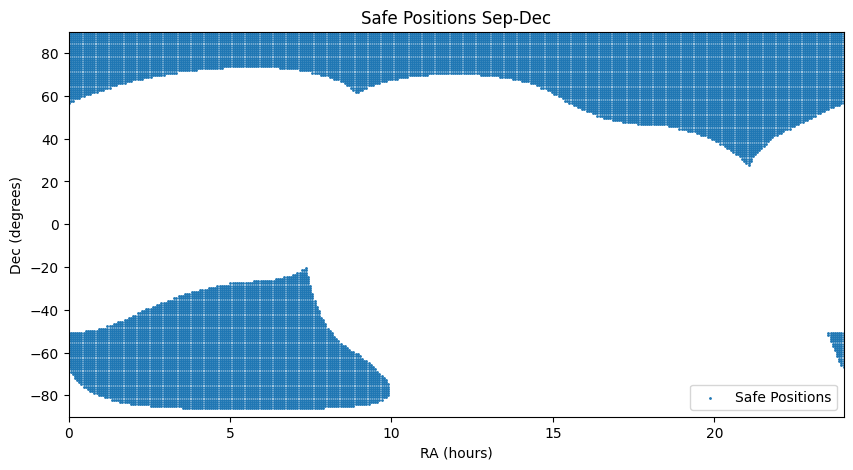

In [6]:
# Splitting the positions into lists of 49 bc for one day positions are calculated 49 times
day_size = 49
moon_daysplit = [moon_eq_values_24[i:i + day_size] for i in range(0, len(moon_eq_values_24), day_size)]
sun_daysplit = [sun_eq_values_24[i:i + day_size] for i in range(0, len(sun_eq_values_24), day_size)]
earth_daysplit = [earth_eq_values_24[i:i + day_size] for i in range(0, len(earth_eq_values_24), day_size)]

# Function to check if there are at least 2 consecutive valid time steps which equals 30min (not 6 anymore)
def has_consecutive_times(times, n=2):
    times = sorted(times)
    for i in range(len(times) - n + 1):
        if times[i + n - 1] - times[i] == n - 1:
            return True
    return False

# Main loop to check for safe RA-Dec combinations
safe_coord_24_new = []

for ra in ra_grid:
    for dec in dec_grid:
        is_safe = True
        
        for d in np.arange(0, 23):  # Loop over days
            t = 0  # time step counter
            safe_t = []  # list for the safe time steps
            
            # Apply moon constraint
            for moon_ra, moon_dec in moon_daysplit[d]:
                if angular_distance(ra, dec, moon_ra, moon_dec) >= 35:
                    safe_t.append(t)
                t += 1
            
            # If there are fewer than 2 valid time steps, break early
            if len(safe_t) < 2:
                is_safe = False
                break
            
            # Apply sun constraint
            sun_day = sun_daysplit[d]
            safe_t_2 = []
            for x in safe_t:
                sun_day_step = sun_day[x]
                sun_distance = angular_distance(ra, dec, sun_day_step[0], sun_day_step[1])
                if 70 <= sun_distance <= 130:  # Sun constraint: between 70 and 130 degrees
                    safe_t_2.append(x)
            
            # If there are fewer than 2 valid time steps after the sun constraint, break early
            if len(safe_t_2) < 2:
                is_safe = False
                break
            
            # Apply earth constraint
            earth_day = earth_daysplit[d]
            safe_t_3 = []
            for y in safe_t_2:
                earth_day_step = earth_day[y]
                if angular_distance(ra, dec, earth_day_step[0], earth_day_step[1]) >= 48:
                    safe_t_3.append(y)
            
            # If there are fewer than 2 valid time steps after the earth constraint, break early
            if len(safe_t_3) < 2:
                is_safe = False
                break
            
            # Check if there are at least 2 consecutive valid time steps
            if not has_consecutive_times(safe_t_3, n=2):
                is_safe = False
                break
        
        # If the ra-dec pair is safe for all days, add it to the list
        if is_safe:
            safe_coord_24_new.append((ra, dec))
            # it may be useful to return the available time slots for every safe-ra-dec pair,
            # which would be a list of 23 lists with at least two elements each
            
safe_ra_24_new = [x[0] for x in safe_coord_24_new]
safe_dec_24_new = [y[1] for y in safe_coord_24_new]

# Plot the results
plt.figure(figsize=(10, 5))
plt.scatter(safe_ra_24_new, safe_dec_24_new, s=1, label='Safe Positions')
plt.xlim(0, 24)
plt.ylim(-90, 90)
plt.xlabel('RA (hours)')
plt.ylabel('Dec (degrees)')
plt.title('Safe Positions Sep-Dec')
plt.legend()
plt.show()

#plt.savefig('all_3m_spring_final', dpi=400)

Now we try to place the fields (or look into which regions are suitable for how many fields) taking into account the distortion the closer we get to the poles:\
Now we need to implement this into our safe sky positions which will reduce the number of fields that we can observe. The declination span for one field will still always be 14.28°, but the RA, now also in degrees, that is necessary to place one field is $\frac{14.28°}{cos(Dec)}$. This means that the necessary space is bigger for the horizontal side that is closer to one of the poles\
$\cdot$ So we need to alter the test for possible fields at certain declination (ranges) with this adjustment\
$\cdot$ Since the field width at the equator is 14.28° we can easily calculate what the maximum absolute value for the upper/lower boundary of a field by solving $\frac{14.28}{cos(\theta)}=360$ for $\theta$. The result is $\pm$87.73°, which means that the highest/lowest field could be between $\pm$73.45° and $\pm$87.73°$

Reminder: If we just say that the most sensitive areas need to are not allowed to overlap, then we have a 170deg^2 field which means 13.04°x13.04°. In other words: the whole fields can have an overlap of 0.62° on the upper and lower side and $\frac{0.62°}{cos(Dec)}$ on the sides

In [7]:
safe_ra_deg = [element * 15 for element in safe_ra_24_new]

safe_coord_deg = list(zip(safe_ra_deg, safe_dec_24_new)) # Creating a new list where both RA and Dec are in degrees

This is a little primitive, but I just want to place a few fields to get a feeling for the distortion:

In [8]:
# Function to plot squares with RA distortion and curved sides
def plot_adjusted_square(ax, ra_center, dec_center, size_deg, num_points, field_num): # Maybe we need to reduce num_points for the field_observeability later (runtime issue)
    """
    Plots a square of a given size (in degrees) centered at (ra_center, dec_center),
    but the RA side is distorted based on the declination, and the square is sampled
    at multiple points to create curved sides.
    
    - num_points controls how many points are sampled along each side of the square.
    """
    # Convert size from degrees to radians
    size_dec = size_deg  # No distortion in Dec size

    # Create arrays of declination points for the left and right sides
    dec_sides = np.linspace(dec_center - size_dec / 2, dec_center + size_dec / 2, num_points)

    # RA for the left and right sides (constant in RA, but dec varies)
    ra_left = ra_center - size_deg / 2 / np.cos(np.deg2rad(dec_sides))
    ra_right = ra_center + size_deg / 2 / np.cos(np.deg2rad(dec_sides))

    # Combine vertices (clockwise order)
    ra_vertices = np.concatenate([ra_left[::-1], ra_right])
    dec_vertices = np.concatenate([dec_sides[::-1], dec_sides])

    # Plot the shape using the transformed vertices
    ax.fill(ra_vertices, dec_vertices, color='red', alpha=0.5)
    ax.text(ra_center, dec_center, str(field_num), fontsize=10, ha='center', va='bottom')
    
    return list(zip(ra_vertices, dec_vertices))

As a first test I want to place a field where the first field in the version without distortion was placed. Since the declination at the upper border is -25.642458100558656°, the dec_center is placed at -32.78245810055866°. The safe positions in RA are between 97.02919220055712° and 111.30919220055712° for the upper boundary, so im taking the middle as the center for now, which is at 104.16919220055712°.\
Field 1 after a few adjustments is at: (103.56919220055712, -33.28245810055866)\
Field 2 placed left of F1 with overlap of sensitive with non-sensitive areas: (86.58919220055712, -35.08245810055866)\
Field 3 placed left of F2: (69.10919220055712, -37.78245810055866)\
Field 4 placed left of F3: (50.82919220055712, -44.38245810055866)\
Field 5 as the left most field, maybe overlapping into the right side(no, bc the overlap into the right side would be tiny but creating an issue with properly displaying the field that's hard to solve for me rn): (17, -58)\
Field 6 right of F5 and below F4: (50.82919220055712, -57.42245810055866)\
Field 7 is placed below F1 as far right as possible: (106.36919220055712, -46.322458100558656)\
Field 8 is below F2/3: (69.10919220055712, -50.822458100558656)\
I will try to place two fields more or less next to each other below F7, if that doesnt work in a useful way, I'll place one below F7 and one below F8 (second version it is)\
Field 9 placed below F7 as far right as possible: (106.36919220055712, -59.362458100558655)\
Field 10 placed below F8: (69.10919220055712, -63.862458100558655)

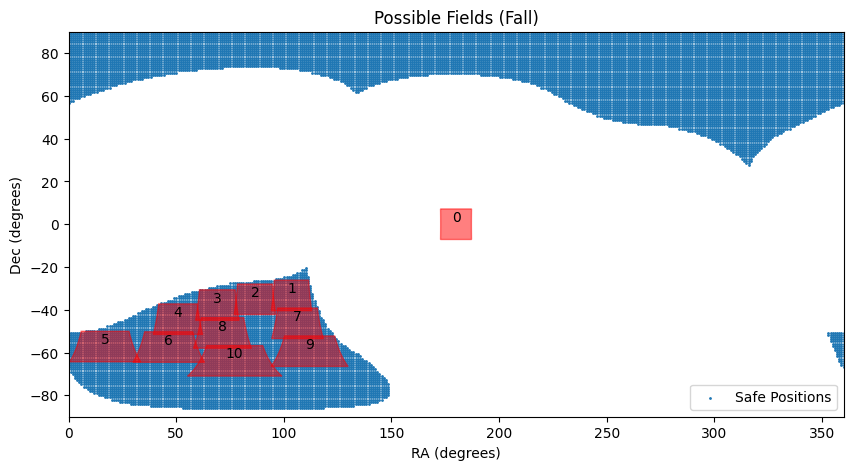

In [9]:
# Set up a plot
fig, ax = plt.subplots(figsize=(10, 5))

# Plot Safe Positions
ax.scatter(safe_ra_deg, safe_dec_24_new, s=1, label='Safe Positions')

# Test case: plot squares of the same "physical" size at different declinations
square_size_deg = 14.28  # 10-degree square
ra_dec_center = [(180, 0), (103.56919220055712, -33.28245810055866), (86.58919220055712, -35.08245810055866),
                 (69.10919220055712, -37.78245810055866), (50.82919220055712, -44.38245810055866),
                 (17, -57.2), (46.52919220055712, -57.42245810055866),
                 (106.36919220055712, -46.322458100558656), (71.50919220055712, -50.822458100558656),
                 (111.96919220055712, -59.362458100558655), (77.20919220055712, -63.862458100558655)] # Center of the fields in (RA,Dec)-tuples

# List to store the fields (each is a list of tuples)
fields = []

# Plotting and storing the points around each field
for i, (ra_center, dec_center) in enumerate(ra_dec_center):
    # Plot the square and retrieve the vertices
    vertices = plot_adjusted_square(ax, ra_center, dec_center, square_size_deg, 50, i)

    # Store the vertices in the list with dynamic names (field_1, field_2, etc.)
    fields.append(vertices)

# Customize plot labels and title
#ax.plot(116.32311977715877, -39.182458100558655, 'go') # Visualizer of overlap as green point
ax.set_xlim(0, 360)
ax.set_ylim(-90, 90)
ax.set_xlabel("RA (degrees)")
ax.set_ylabel("Dec (degrees)")
ax.set_title("Possible Fields (Fall)")
ax.legend()
#plt.grid(True)
plt.show()

Below we have a test whether the sensitive areas of two fields overlap. For this purpose we always look how far the (sensitive areas of the) fields extend towards each other at the maximum declination (of the sensitive area) of the field that is further from the poles:

In [10]:
# A test whether Field 6 and 10 overlap with their sensitive areas
field6_low_sen = ra_dec_center[6][1]-7.14+0.62 # The lower edge of the sensitive area of Field 5 (generally of the higher one)
field10_left_sen = ra_dec_center[10][0]-(6.52/np.cos(np.deg2rad(field6_low_sen))) # leftmost RA of the right field at the lower edge og the higher one
field6_right_sen = ra_dec_center[6][0]+(6.52/np.cos(np.deg2rad(field6_low_sen))) # rightmost RA of the left field at the lower sensitive area edge of the higher one
print("The sensitive area of Field10 begins at",field10_left_sen,"° and the sensitive area of Field6 at the same height ends at",field6_right_sen)

The sensitive area of Field10 begins at 62.366505797763445 ° and the sensitive area of Field6 at the same height ends at 61.3718786033508


Now we still need a test to see whether the fields are actually observable as a whole for one time slot of 2h45min every day and we dont just have points that are individually observable at different times:

In [11]:
# Creating the new moon/sun/earth_dayplits, which contain both RA and Dec values in degrees

# First we just define the old daysplits again
day_size = 49
moon_daysplit = [moon_eq_values_24[i:i + day_size] for i in range(0, len(moon_eq_values_24), day_size)]
sun_daysplit = [sun_eq_values_24[i:i + day_size] for i in range(0, len(sun_eq_values_24), day_size)]
earth_daysplit = [earth_eq_values_24[i:i + day_size] for i in range(0, len(earth_eq_values_24), day_size)]

# Loop through each day in the daysplits
for day in moon_daysplit:
    # Loop through each tuple in a day
    for i in range(len(day)):
        # Multiply the first element of the tuple by 15 and update the tuple
        day[i] = (day[i][0] * 15, day[i][1])
for day in sun_daysplit:
    # Loop through each tuple in a day
    for i in range(len(day)):
        # Multiply the first element of the tuple by 15 and update the tuple
        day[i] = (day[i][0] * 15, day[i][1])
for day in earth_daysplit:
    # Loop through each tuple in a day
    for i in range(len(day)):
        # Multiply the first element of the tuple by 15 and update the tuple
        day[i] = (day[i][0] * 15, day[i][1])

The field observability needs to return the available time slots for every day. Then we have to compare if the fields from one group actually are observable in some order. Remember: Every field only needs 15minutes of observation time every day, so it's sufficient if it has two consecutive time slots (which is actually 30min)

In [12]:
# We need a new function for the angular distance because we now use degrees for both the Declination and the RA

#Calculation of the angular distance in equatorial coordinates
def angular_distance_deg(ra1, dec1, ra2, dec2):
    ra1 = np.deg2rad(ra1)
    ra2 = np.deg2rad(ra2)
    dec1 = np.deg2rad(dec1)
    dec2 = np.deg2rad(dec2)
    cos_distance = np.sin(dec1) * np.sin(dec2) + np.cos(dec1) * np.cos(dec2) * np.cos(ra1 - ra2)
    distance = np.arccos(cos_distance)
    return np.rad2deg(distance)

# We also need to modify the ra_grid to degrees instead of hours (and also the moon_ra, sun_ra and earth_ra values)
ra_grid_deg = np.linspace(0, 360, 360)  # RA from 0 to 360 degrees


def field_observability(field_sides): # we just need to include the RA and Dec positions that would be within the Square
    ra_sides, dec_sides = zip(*field_sides)
    daily_safe_times = [] # A list that will contain the safe time slots for every day
    for d in np.arange(0,23):
        safe_t = None  # Reset safe time steps for each day
        for i, dec in enumerate(dec_sides[:50]): # We only need the first 50 Dec values because the second 50 are the same
            field_ra = []
            field_ra.append(ra_sides[i]) # Including the left RA end point
            j = -(i+1)
            for ra_pre in ra_grid_deg:
                if ra_sides[i] <= ra_pre <= ra_sides[j]:
                    field_ra.append(ra_pre)
            field_ra.append(ra_sides[j]) # Including the right RA end point
            for ra in field_ra:
                t = 0  # time step counter
                safe_t_candidate = []  # list for the safe time steps

                # Apply moon constraint
                for moon_ra, moon_dec in moon_daysplit[d]:
                    if angular_distance_deg(ra, dec, moon_ra, moon_dec) >= 35:
                        safe_t_candidate.append(t)
                    t += 1

                # If there are fewer than 2 valid time steps, we can skip this coordinate
                if len(safe_t_candidate) < 2:
                    return False, ra, dec  # This field is not observable for this day

                # Apply sun constraint
                sun_day = sun_daysplit[d]
                safe_t_2 = []
                for x in safe_t_candidate:
                    sun_day_step = sun_day[x]
                    sun_distance = angular_distance_deg(ra, dec, sun_day_step[0], sun_day_step[1])
                    if 70 <= sun_distance <= 130:
                        safe_t_2.append(x)

                # If there are fewer than 2 valid time steps after sun constraint, skip this coordinate
                if len(safe_t_2) < 2:
                    return False, ra, dec

                # Apply earth constraint
                earth_day = earth_daysplit[d]
                safe_t_3 = []
                for y in safe_t_2:
                    earth_day_step = earth_day[y]
                    if angular_distance_deg(ra, dec, earth_day_step[0], earth_day_step[1]) >= 48:
                        safe_t_3.append(y)

                # If there are fewer than 2 valid time steps after earth constraint or no consecutive steps, skip
                if len(safe_t_3) < 2 or not has_consecutive_times(safe_t_3, n=2):
                    return False, ra, dec  # If no valid set of 2 consecutive time steps, return False

                # If it's the first coordinate, set the safe time steps for this day
                if safe_t is None:
                    safe_t = safe_t_3
                else:
                    # Check if the current RA/Dec combination can be observed for the same time steps as safe_t and naming it safe_t again since 
                    # otherwise we only compare the safe time slots from the first coordinate to all the others
                    safe_t = list(set(safe_t).intersection(safe_t_3))
                    if len(safe_t) < 2 or not has_consecutive_times(safe_t, n=2):
                        return False, ra, dec  # This field can't be observed for the same 2 consecutive time steps
        # Filling the list of with lists that holds the safe time slots for every day for this field
        daily_safe_times.append(safe_t)
                    
    return daily_safe_times # If the observation is safe/possible for one entire field it just returns the daily safe time slots and not True anymore

Now we need to compare the time slots for every single day, i guess we can do that with the "has_consecutive_times" function. Remember that we only need 15min of observation time for one field and have a maximum slew time of 1.5min between two fields. So for example, it's possible to observe 3 fields within 2 time slots, since the observation including slew time takes up to 45min+3min. We also need to keep in mind that the fields need to be within 40 degs of angular distance, so we can't have some restrictions to the order in which we must observe the fields. (Maybe we can visualize this first off by drawing 40deg circles around the centers of the fields.)

In [13]:
# Testing the fields if they are safe in general and which time slots are available every day

field1_observable = field_observability(fields[1])
field1_observable

[[39, 40, 41, 42, 43, 44, 45, 46, 47, 48],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  39,
  40,
 

In [14]:
field2_observable = field_observability(fields[2])
field2_observable

[[0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  

In [15]:
field3_observable = field_observability(fields[3])
field3_observable

[[0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  

In [16]:
field4_observable = field_observability(fields[4])
field4_observable

[[0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  

In [17]:
field5_observable = field_observability(fields[5])
field5_observable

[[41, 42, 43, 44, 45, 46, 47, 48],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,


In [18]:
field6_observable = field_observability(fields[6])
field6_observable

[[0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,

In [19]:
field7_observable = field_observability(fields[7])
field7_observable

[[38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  1

In [20]:
field8_observable = field_observability(fields[8])
field8_observable

[[0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  

In [21]:
field9_observable = field_observability(fields[9])
field9_observable

[[39, 40, 41, 42, 43, 44, 45, 46, 47, 48],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18

In [22]:
field10_observable = field_observability(fields[10])
field10_observable

[[0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,

Let's see if it's possible to establish some order in which we could observe the fields. First try: Just taking the time slots that are included in all fields for one specific day, which would allow us to observe in any order (only that the fields are not all within 40 degrees of each other)

In [23]:
def nth_day_common_timeslots(n):
    nth_day = [] # A list that contains the lists of every available time slot for each field on the nth-day
    for i in np.arange(1,11):
        var = f'field{i}_observable'
        var2 = globals()[var]
        nth_day.append(var2[n])
    common_elements = set(nth_day[0])  # Start with the first list
    for lst in nth_day[1:]:  # Iterate through the remaining lists
        common_elements.intersection_update(lst)
    nth_day_common_timeslots = list(common_elements)
    return nth_day_common_timeslots

In [24]:
for n in np.arange(0,23):
    print(nth_day_common_timeslots(n))

[41, 42, 43, 44, 45, 46, 47, 48]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]
[0, 

So apparently the time slots from 41 to 48 are available every day. So it would certainly work to use these every day, because 41 translates to 8:30 pm and 48 means 11:59pm. So that gives us 3.5 hours, which is sufficient even when every field would be at a distance of 40°. \
Only for the last day, we still would need to see, if an overlap into December 22nd makes sense (or just observe between 38 and 48 on that day)

Now we get to the part, where we introduce the dust map (SFD98 in this case, at least for now):

In [25]:
!pip install healpy

Defaulting to user installation because normal site-packages is not writeable


This is the SFD98 map, I had to invert both the x and y axis, because only then it looks like what I think the dust map should look like, from what I've seen from Yossi and also the High-cadence survey presentation:

<Figure size 1000x500 with 0 Axes>

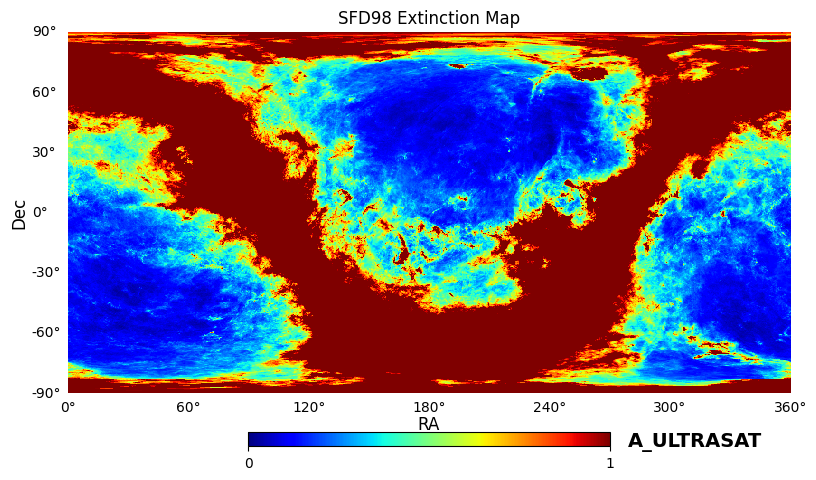

In [26]:
import healpy as hp
import matplotlib.pyplot as plt

# Replace this with the path to your lambda_sfd_ebv.fits file, source: https://lambda.gsfc.nasa.gov/product/foreground/fg_sfd_get.html
sfd_file = 'lambda_sfd_ebv.fits'

# Load the HEALPix data
ebv_map = hp.read_map(sfd_file, hdu=1)

# Create a figure with specific aspect ratio (width=2xheight)
fig = plt.figure(figsize=(10, 5))

# Plot the SFD98 extinction map
hp.cartview(6.7*ebv_map, coord=['G', 'C'], title="SFD98 Extinction Map", cmap='jet', unit='A_ULTRASAT', min=0, max=1, notext=True)

# Flip the plot upside down because for some reason the data is upside down
plt.gca().invert_yaxis()

# I think plot also needs to be flipped along the x-axis
plt.gca().invert_xaxis()

# Add manual labels for Right Ascension (x-axis)
plt.text(0.5, -0.1, 'RA', ha='center', fontsize=12, transform=plt.gca().transAxes)

# Add manual labels for Declination (y-axis)
plt.text(-0.08, 0.5, 'Dec', va='center', rotation='vertical', fontsize=12, transform=plt.gca().transAxes)

# Add RA ticks manually
for ra, label in zip([0, 60, 120, 180, 240, 300, 360], ['0°', '60°', '120°', '180°', '240°', '300°', '360°']):
    plt.text(ra/360, -0.05, label, ha='center', transform=plt.gca().transAxes)

# Add Dec ticks manually
for dec, label in zip([-90, -60, -30, 0, 30, 60, 90], ['-90°', '-60°', '-30°', '0°', '30°', '60°', '90°']):
    plt.text(-0.05, (dec+90)/180, label, va='center', transform=plt.gca().transAxes)

# Show the plot
plt.show()

Before we can include the proposed fields we need to alter the plot_adjusted_square function a little bit, so that it actually works here:

In [50]:
# Function to plot squares with RA distortion and curved sides
def plot_adjusted_square2(ra_center, dec_center, size_deg, num_points, field_num): # Maybe we need to reduce num_points for the field_observeability later (runtime issue)
    """
    Plots a square of a given size (in degrees) centered at (ra_center, dec_center),
    but the RA side is distorted based on the declination, and the square is sampled
    at multiple points to create curved sides.
    
    - num_points controls how many points are sampled along each side of the square.
    """
    # Convert size from degrees to radians
    size_dec = size_deg  # No distortion in Dec size

    ra_center = ra_center - 180 # shifting the ra_center so they fit with the new coordinates
    ra_center = -ra_center # Inverting at the y-axis
    dec_center = -dec_center # Inverting at the x-axis
    
    # Create arrays of declination points for the left and right sides
    dec_sides = np.linspace(dec_center - size_dec / 2, dec_center + size_dec / 2, num_points)

    # RA for the left and right sides (constant in RA, but dec varies)
    ra_left = ra_center - size_deg / 2 / np.cos(np.deg2rad(dec_sides))
    ra_right = ra_center + size_deg / 2 / np.cos(np.deg2rad(dec_sides))

    # Combine vertices (clockwise order)
    ra_vertices = np.concatenate([ra_left[::-1], ra_right])
    dec_vertices = np.concatenate([dec_sides[::-1], dec_sides])

    # Plot the shape using the transformed vertices
    plt.fill(ra_vertices, dec_vertices, color='red', alpha=0.5)
    plt.text(ra_center, dec_center, str(field_num), fontsize=10, ha='center', va='bottom') # Giving the fields numbers
    # Note that we only use the right and left side of the square, we dont really need the top and bottom because
    # we dont have any regions with narrow vertical peaks, so we can just test whether the sides fulfill field_observeability

    return list(zip(ra_vertices, dec_vertices))

Now we include the safe sky positions and the proposed fields in the same image we have for the SFD98 map:

<Figure size 1000x500 with 0 Axes>

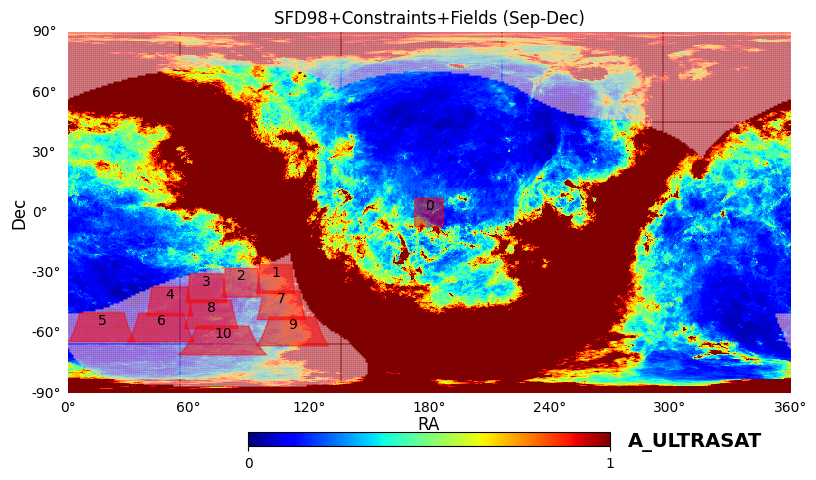

In [32]:
# Convert RA/Dec (theta, phi) to Healpy pixel indices
safe_dec_nparray = np.array(safe_dec_24_new) # Converting the Dec points into np.array
safe_dec_nparray = -safe_dec_nparray # Inverting at the x axis, to match the new coordinate system
safe_ra_nparray = np.array(safe_ra_deg) # Converting the RA points into an np.array
ra_data_wrapped = safe_ra_nparray -180 # Switching to a system where RA ranges from -180° to 180°
ra_data_wrapped = -ra_data_wrapped # Inverting at the y axis because we also need to flip the other data later on

# Plot the overlapped map using `cartview` in Equatorial coordinates
fig = plt.figure(figsize=(10, 5))

# Plot the SFD98 extinction map
hp.cartview(6.7*ebv_map, coord=['G', 'C'], title="SFD98+Constraints+Fields (Sep-Dec)", cmap='jet', unit='A_ULTRASAT', min=0, max=1, notext=True)

# Flip the plot upside down because for some reason the data is upside down
plt.gca().invert_yaxis()

# I think plot also needs to be flipped along the x-axis
plt.gca().invert_xaxis()

# Overlay your RA/Dec points directly on the map
plt.scatter(ra_data_wrapped, safe_dec_nparray, color='pink', alpha=0.4, s=1, marker='o')
    
for i, (ra_center, dec_center) in enumerate(ra_dec_center):
   plot_adjusted_square2(ra_center, dec_center, square_size_deg, 50, i)

# Add labels for RA/Dec if needed
plt.xlabel('Right Ascension [degrees]', fontsize=12)
plt.ylabel('Declination [degrees]', fontsize=12)

# Add manual labels for Right Ascension (x-axis)
plt.text(0.5, -0.1, 'RA', ha='center', fontsize=12, transform=plt.gca().transAxes)

# Add manual labels for Declination (y-axis)
plt.text(-0.08, 0.5, 'Dec', va='center', rotation='vertical', fontsize=12, transform=plt.gca().transAxes)

# Add RA ticks manually
for ra, label in zip([0, 60, 120, 180, 240, 300, 360], ['0°', '60°', '120°', '180°', '240°', '300°', '360°']):
    plt.text(ra/360, -0.05, label, ha='center', transform=plt.gca().transAxes)

# Add Dec ticks manually
for dec, label in zip([-90, -60, -30, 0, 30, 60, 90], ['-90°', '-60°', '-30°', '0°', '30°', '60°', '90°']):
    plt.text(-0.05, (dec+90)/180, label, va='center', transform=plt.gca().transAxes)

# Show the plot
#plt.legend()
plt.show()

Let's try to move the fields around some more, keeping them out of the high reddening zones as good as possible while still staying as far away from the south pole as possible. Field 10 has been moved as close to Field 6 as possible, Field 7 directly above 2 and as close to Field 8 as possible, since F7 moved down, F9 had to move down as well and to the left as far as possible, F1 just down a little, but maybe that didnt even move it away from the reddening zone

In [65]:
# Defining a new ra_dec_center
ra_dec_center_2 = [(180, 0), (103.56919220055712, -35.08245810055866), (86.58919220055712, -35.08245810055866),
                 (69.10919220055712, -37.78245810055866), (50.82919220055712, -44.38245810055866),
                 (17, -57.2), (46.52919220055712, -57.42245810055866),
                 (94.06919220055712, -48.12245810055866), (71.50919220055712, -50.822458100558656),
                 (110.56919220055712, -61.16245810055866), (76.21919220055712, -63.862458100558655)] # Center of the fields in (RA,Dec)-tuples

<Figure size 1000x500 with 0 Axes>

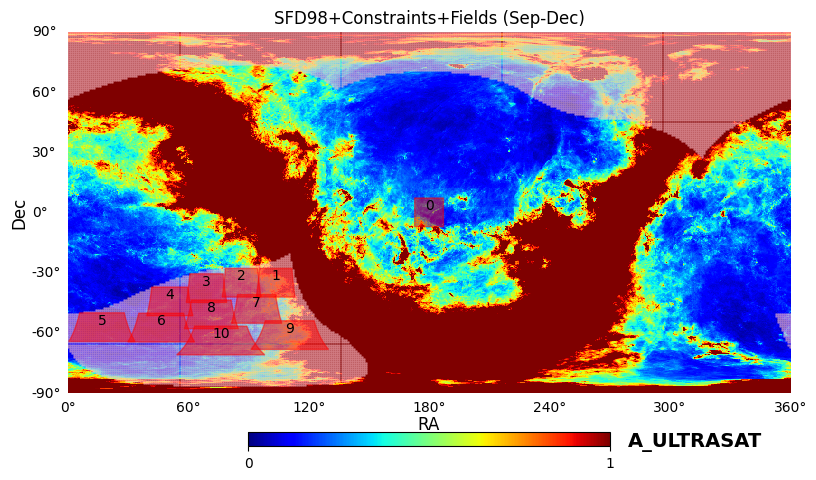

In [66]:
# Plot the overlapped map using `cartview` in Equatorial coordinates
fig = plt.figure(figsize=(10, 5))

# Plot the SFD98 extinction map
hp.cartview(6.7*ebv_map, coord=['G', 'C'], title="SFD98+Constraints+Fields (Sep-Dec)", cmap='jet', unit='A_ULTRASAT', min=0, max=1, notext=True)

# Flip the plot upside down because for some reason the data is upside down
plt.gca().invert_yaxis()

# I think plot also needs to be flipped along the x-axis
plt.gca().invert_xaxis()

# Overlay your RA/Dec points directly on the map
plt.scatter(ra_data_wrapped, safe_dec_nparray, color='pink', alpha=0.4, s=1, marker='o')
    
# List to store the fields (each is a list of tuples)
fields_2 = []

for i, (ra_center, dec_center) in enumerate(ra_dec_center_2):
    # Plot the square and retrieve the vertices
    vertices_2 = plot_adjusted_square2(ra_center, dec_center, square_size_deg, 50, i)

    # Store the vertices in the list with dynamic names (field_1, field_2, etc.)
    fields_2.append(vertices_2)

# Add labels for RA/Dec if needed
plt.xlabel('Right Ascension [degrees]', fontsize=12)
plt.ylabel('Declination [degrees]', fontsize=12)

# Add manual labels for Right Ascension (x-axis)
plt.text(0.5, -0.1, 'RA', ha='center', fontsize=12, transform=plt.gca().transAxes)

# Add manual labels for Declination (y-axis)
plt.text(-0.08, 0.5, 'Dec', va='center', rotation='vertical', fontsize=12, transform=plt.gca().transAxes)

# Add RA ticks manually
for ra, label in zip([0, 60, 120, 180, 240, 300, 360], ['0°', '60°', '120°', '180°', '240°', '300°', '360°']):
    plt.text(ra/360, -0.05, label, ha='center', transform=plt.gca().transAxes)

# Add Dec ticks manually
for dec, label in zip([-90, -60, -30, 0, 30, 60, 90], ['-90°', '-60°', '-30°', '0°', '30°', '60°', '90°']):
    plt.text(-0.05, (dec+90)/180, label, va='center', transform=plt.gca().transAxes)

# Show the plot
#plt.legend()
plt.show()

In [63]:
# A test whether Field x and y overlap with their sensitive areas
field9_low_sen = ra_dec_center_2[9][1]-7.14+0.62 # The lower edge of the sensitive area of Field x (generally of the one closer to the equator)
field9_left_sen = ra_dec_center_2[9][0]-(6.52/np.cos(np.deg2rad(field9_low_sen))) # leftmost RA of the right field at the lower edge of the higher one
field10_right_sen = ra_dec_center_2[10][0]+(6.52/np.cos(np.deg2rad(field9_low_sen))) # rightmost RA of the left field at the lower sensitive area edge of the higher one
print("The sensitive area of Field9 begins at",field9_left_sen,"° and the sensitive area of Field10 at the same height ends at",field10_right_sen)

The sensitive area of Field9 begins at 93.39952302682458 ° and the sensitive area of Field10 at the same height ends at 93.38886137428966


In [68]:
# Testing the observability of Field 1 at it's new position
ra_sides_1, dec_sides_1 = zip(*fields_2[1])
ra_sides_1_np = np.array(ra_sides_1) # transforming to np.array bc otherwise the inversion wont work
dec_sides_1_np = np.array(dec_sides_1) # transforming to np.array bc otherwise the inversion wont work

dec_sides_1_np = -dec_sides_1_np # Undoing the x-axis inversion
ra_sides_1_np = -ra_sides_1_np # Undoing the y-axis inversion
ra_sides_1_np = ra_sides_1_np + 180 # moving the coordinates back, so the field_observability function does the right calculations
field_1_adjust = list(zip(ra_sides_1_np, dec_sides_1_np)) # rezipping the field sides

field1_observable_2 = field_observability(field_1_adjust)
field1_observable_2

[[9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,


In [57]:
# Testing the observability of Field 7 at it's new position
ra_sides_7, dec_sides_7 = zip(*fields_2[7])
ra_sides_7_np = np.array(ra_sides_7) # transforming to np.array bc otherwise the inversion wont work
dec_sides_7_np = np.array(dec_sides_7) # transforming to np.array bc otherwise the inversion wont work

dec_sides_7_np = -dec_sides_7_np # Undoing the x-axis inversion
ra_sides_7_np = -ra_sides_7_np # Undoing the y-axis inversion
ra_sides_7_np = ra_sides_7_np + 180 # moving the coordinates back, so the field_observability function does the right calculations
field_7_adjust = list(zip(ra_sides_7_np, dec_sides_7_np)) # rezipping the field sides

field7_observable_2 = field_observability(field_7_adjust)
field7_observable_2

[[0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  

In [70]:
# Testing the observability of Field 9 at it's new position
ra_sides_9, dec_sides_9 = zip(*fields_2[9])
ra_sides_9_np = np.array(ra_sides_9) # transforming to np.array bc otherwise the inversion wont work
dec_sides_9_np = np.array(dec_sides_9) # transforming to np.array bc otherwise the inversion wont work

dec_sides_9_np = -dec_sides_9_np # Undoing the x-axis inversion
ra_sides_9_np = -ra_sides_9_np # Undoing the y-axis inversion
ra_sides_9_np = ra_sides_9_np + 180 # moving the coordinates back, so the field_observability function does the right calculations
field_9_adjust = list(zip(ra_sides_9_np, dec_sides_9_np)) # rezipping the field sides

field9_observable_2 = field_observability(field_9_adjust)
field9_observable_2

[[0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,

In [52]:
# Testing the observability of Field 10 at it's new position
ra_sides_10, dec_sides_10 = zip(*fields_2[10])
ra_sides_10_np = np.array(ra_sides_10) # transforming to np.array bc otherwise the inversion wont work
dec_sides_10_np = np.array(dec_sides_10) # transforming to np.array bc otherwise the inversion wont work

dec_sides_10_np = -dec_sides_10_np # Undoing the x-axis inversion
ra_sides_10_np = -ra_sides_10_np # Undoing the y-axis inversion
ra_sides_10_np = ra_sides_10_np + 180 # moving the coordinates back, so the field_observability function does the right calculations
field_10_adjust = list(zip(ra_sides_10_np, dec_sides_10_np)) # rezipping the field sides

field10_observable_2 = field_observability(field_10_adjust)
field10_observable_2

[[0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,

Now we just need to look for an observation order again, using the nth_day_common_timeslots function in a slightly altered version with our new fields, since Field 1,7,9,10 got moved we need to enter those manually:

In [71]:
# new nth_day_common_timeslots function
def nth_day_common_timeslots_2(n):
    nth_day = [] # A list that contains the lists of every available time slot for each field on the nth-day
    for i in np.array([2,3,4,5,6,8]):
        var = f'field{i}_observable'
        var2 = globals()[var]
        nth_day.append(var2[n])
    for j in np.array([1,7,9,10]):
        var = f'field{j}_observable_2'
        var2 = globals()[var]
        nth_day.append(var2[n])
    common_elements = set(nth_day[0])  # Start with the first list
    for lst in nth_day[1:]:  # Iterate through the remaining lists
        common_elements.intersection_update(lst)
    nth_day_common_timeslots = list(common_elements)
    return nth_day_common_timeslots

In [72]:
for n in np.arange(0,23):
    print(nth_day_common_timeslots_2(n))

[41, 42, 43, 44, 45, 46, 47, 48]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 38, 39, 40, 41, 42, 43, 44, 45, 

With the new arrangment of fields choosing the timeslots stays the same as before as every day still has at least 8 consecutive time slots that allow an observation.

And finally I also need one version where it's only the proposed fields and the Dust map, but not the safe sky regions:

<Figure size 1000x500 with 0 Axes>

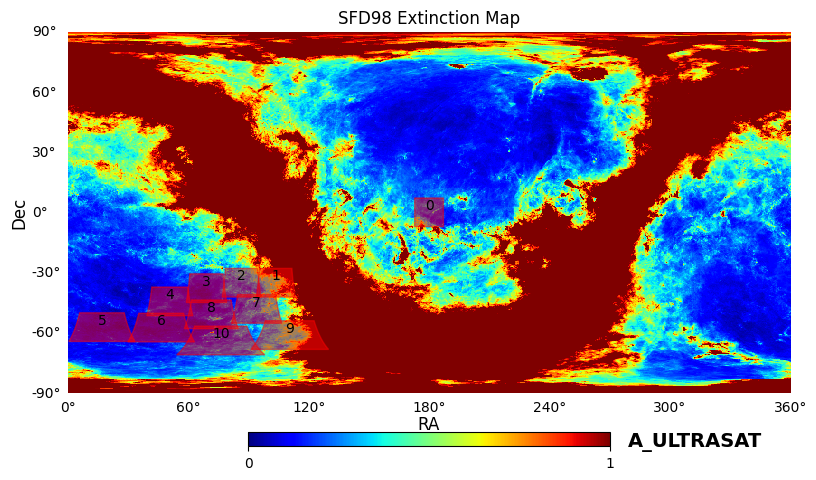

In [69]:
# Plot the overlapped map using `cartview` in Equatorial coordinates
fig = plt.figure(figsize=(10, 5))

# Plot the masked Healpy map in equatorial coordinates
#hp.cartview(masked_ebv_map, coord=['G', 'C'], title="SFD98 Extinction Map with RA/Dec Points", 
#            cmap='jet', unit='E(B-V)', min=0, max=1)

# Plot the SFD98 extinction map
hp.cartview(6.7*ebv_map, coord=['G', 'C'], title="SFD98 Extinction Map", cmap='jet', unit='A_ULTRASAT', min=0, max=1, notext=True)

# Flip the plot upside down because for some reason the data is upside down
plt.gca().invert_yaxis()

# I think plot also needs to be flipped along the x-axis
plt.gca().invert_xaxis()

# Overlay your RA/Dec points directly on the map
#plt.scatter(ra_data_wrapped, safe_dec_nparray, color='pink', alpha=0.3, s=1, marker='o', label='RA/Dec Data Points')

for i, (ra_center, dec_center) in enumerate(ra_dec_center_2):
   plot_adjusted_square2(ra_center, dec_center, square_size_deg, 50, i)

# Add manual labels for Right Ascension (x-axis)
plt.text(0.5, -0.1, 'RA', ha='center', fontsize=12, transform=plt.gca().transAxes)

# Add manual labels for Declination (y-axis)
plt.text(-0.08, 0.5, 'Dec', va='center', rotation='vertical', fontsize=12, transform=plt.gca().transAxes)

# Add RA ticks manually
for ra, label in zip([0, 60, 120, 180, 240, 300, 360], ['0°', '60°', '120°', '180°', '240°', '300°', '360°']):
    plt.text(ra/360, -0.05, label, ha='center', transform=plt.gca().transAxes)

# Add Dec ticks manually
for dec, label in zip([-90, -60, -30, 0, 30, 60, 90], ['-90°', '-60°', '-30°', '0°', '30°', '60°', '90°']):
    plt.text(-0.05, (dec+90)/180, label, va='center', transform=plt.gca().transAxes)

# Add labels for RA/Dec if needed
plt.xlabel('Right Ascension [degrees]', fontsize=12)
plt.ylabel('Declination [degrees]', fontsize=12)

# Show the plot
#plt.legend()
plt.show()

Let's go into the larger, but narrower, __upper region__. We want to keep the majority of every field outside the red, stay entirely in the secure observation zones and below an declination of 75°:

In [228]:
# new ra_dec_center for the upper region
ra_dec_center_up =  [(180, 0), (240.3, 67.86), (271.96, 54.22),
                     (287, 67.26)] # Center of the fields in (RA,Dec)-tuples

<Figure size 1000x500 with 0 Axes>

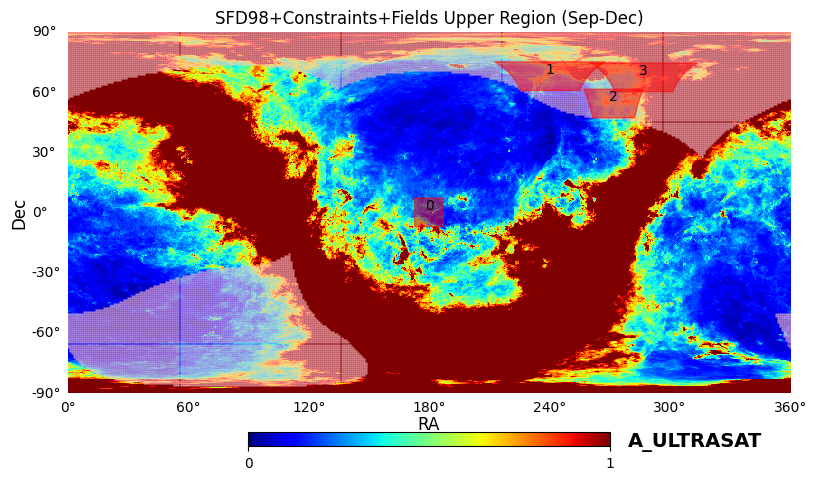

In [229]:
# Plot the overlapped map using `cartview` in Equatorial coordinates
fig = plt.figure(figsize=(10, 5))

# Plot the SFD98 extinction map
hp.cartview(6.7*ebv_map, coord=['G', 'C'], title="SFD98+Constraints+Fields Upper Region (Sep-Dec)", cmap='jet', unit='A_ULTRASAT', min=0, max=1, notext=True)

# Flip the plot upside down because for some reason the data is upside down
plt.gca().invert_yaxis()

# I think plot also needs to be flipped along the x-axis
plt.gca().invert_xaxis()

# Overlay your RA/Dec points directly on the map
plt.scatter(ra_data_wrapped, safe_dec_nparray, color='pink', alpha=0.4, s=1, marker='o')
    
# List to store the fields (each is a list of tuples)
fields_up = []

for i, (ra_center, dec_center) in enumerate(ra_dec_center_up):
    # Plot the square and retrieve the vertices
    vertices_up = plot_adjusted_square2(ra_center, dec_center, square_size_deg, 50, i)

    # Store the vertices in the list with dynamic names (field_1, field_2, etc.)
    fields_up.append(vertices_up)

# Add labels for RA/Dec if needed
plt.xlabel('Right Ascension [degrees]', fontsize=12)
plt.ylabel('Declination [degrees]', fontsize=12)

# Add manual labels for Right Ascension (x-axis)
plt.text(0.5, -0.1, 'RA', ha='center', fontsize=12, transform=plt.gca().transAxes)

# Add manual labels for Declination (y-axis)
plt.text(-0.08, 0.5, 'Dec', va='center', rotation='vertical', fontsize=12, transform=plt.gca().transAxes)

# Add RA ticks manually
for ra, label in zip([0, 60, 120, 180, 240, 300, 360], ['0°', '60°', '120°', '180°', '240°', '300°', '360°']):
    plt.text(ra/360, -0.05, label, ha='center', transform=plt.gca().transAxes)

# Add Dec ticks manually
for dec, label in zip([-90, -60, -30, 0, 30, 60, 90], ['-90°', '-60°', '-30°', '0°', '30°', '60°', '90°']):
    plt.text(-0.05, (dec+90)/180, label, va='center', transform=plt.gca().transAxes)

#plt.plot(-89.67293235105421, -46.26, 'go') # I use this point to show where the field is overlapping with the non-safe region

# Show the plot
#plt.legend()
plt.show()

In [230]:
# A test whether Field x and y overlap with their sensitive areas
field3_up_sen = ra_dec_center_up[3][1]+7.14-0.62 # The upper edge of the field closer to the equator
field1_right_sen = ra_dec_center_up[1][0]+(6.52/np.cos(np.deg2rad(field3_up_sen))) # RA of the upper right corner of the sensitive area of F5
field3_left_sen = ra_dec_center_up[3][0]-(6.52/np.cos(np.deg2rad(field3_up_sen))) # RA of the left most point of F5 at the Dec of F5 upper sensitive area edge
print("The sensitive area of Field 1 ends at",field1_right_sen,"° and the sensitive area of Field 3 at the same height begins at",field3_left_sen)

The sensitive area of Field 1 ends at 263.6418769451363 ° and the sensitive area of Field 3 at the same height begins at 263.6581230548637


Of course we also need to ensure that the picked fields are actually observable. If we have a __point that doesnt fit__, we can display it after reversing the steps of transformation. First subtract 180 from the RA coordinate and afterwards invert both the RA and the Dec.

In [134]:
# Testing the observability of Field 1 in the lower region
ra_sides_up_1, dec_sides_up_1 = zip(*fields_up[1])
ra_sides_up_1_np = np.array(ra_sides_up_1) # transforming to np.array bc otherwise the inversion wont work
dec_sides_up_1_np = np.array(dec_sides_up_1) # transforming to np.array bc otherwise the inversion wont work

dec_sides_up_1_np = -dec_sides_up_1_np # Undoing the x-axis inversion
ra_sides_up_1_np = -ra_sides_up_1_np # Undoing the y-axis inversion
ra_sides_up_1_np = ra_sides_up_1_np + 180 # moving the coordinates back, so the field_observability function does the right calculations
field_up_1 = list(zip(ra_sides_up_1_np, dec_sides_up_1_np)) # rezipping the field sides

field1_observable_up = field_observability(field_up_1)
field1_observable_up

[[24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
 

In [218]:
# Testing the observability of Field 2 in the lower region
ra_sides_up_2, dec_sides_up_2 = zip(*fields_up[2])
ra_sides_up_2_np = np.array(ra_sides_up_2) # transforming to np.array bc otherwise the inversion wont work
dec_sides_up_2_np = np.array(dec_sides_up_2) # transforming to np.array bc otherwise the inversion wont work

dec_sides_up_2_np = -dec_sides_up_2_np # Undoing the x-axis inversion
ra_sides_up_2_np = -ra_sides_up_2_np # Undoing the y-axis inversion
ra_sides_up_2_np = ra_sides_up_2_np + 180 # moving the coordinates back, so the field_observability function does the right calculations
field_up_2 = list(zip(ra_sides_up_2_np, dec_sides_up_2_np)) # rezipping the field sides

field2_observable_up = field_observability(field_up_2)
field2_observable_up

[[0,
  1,
  2,
  3,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 [0,
  1,
  2,
  3,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 [0,
  1,
  2,
  3,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 [0,
  1,
  2,
  3,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  4

In [231]:
# Testing the observability of Field 3 in the lower region
ra_sides_up_3, dec_sides_up_3 = zip(*fields_up[3])
ra_sides_up_3_np = np.array(ra_sides_up_3) # transforming to np.array bc otherwise the inversion wont work
dec_sides_up_3_np = np.array(dec_sides_up_3) # transforming to np.array bc otherwise the inversion wont work

dec_sides_up_3_np = -dec_sides_up_3_np # Undoing the x-axis inversion
ra_sides_up_3_np = -ra_sides_up_3_np # Undoing the y-axis inversion
ra_sides_up_3_np = ra_sides_up_3_np + 180 # moving the coordinates back, so the field_observability function does the right calculations
field_up_3 = list(zip(ra_sides_up_3_np, dec_sides_up_3_np)) # rezipping the field sides

field3_observable_up = field_observability(field_up_3)
field3_observable_up

[[0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,